In [5]:
#Set the path to the hawkes library
import os 
import sys

module_dir = os.path.join("..", 'build') # path to the hawkes library and sometimes it's 'build/Debug' or 'build/Release' for windows    
sys.path.insert(0, module_dir)

In [8]:
import hawkes
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# Hawkes Tests

In [2]:
def hex_to_rgb(value):
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0, 1, len(rgb_list)))

    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [3]:
# Test the simulate_hawkes function
mu = np.array([2.0, 1.5, 0.01, 0.1, 0.8, 2.0, 0.3, 0.2, 0.5, 0.01])
alpha = np.array([
    [0.5, 0.1, 3.0, 2.0, 0.4, 2.4, 0.1, 1.5, 0.1, 0.1],
    [0.2, 0.6, 3.0, 0.1, 0.2, 0.1, 0.7, 1.2, 0.1, 0.5],
    [3.5, 3.0, 4.0, 3.0, 0.1, 2.0, 0.2, 1.3, 0.1, 2.0],
    [0.1, 0.2, 0.2, 0.5, 0.1, 0.1, 0.1, 0.2, 0.1, 2.0],
    [0.3, 0.1, 1.1, 1.0, 0.6, 0.8, 0.1, 1.5, 0.1, 0.1],
    [0.1, 0.2, 0.1, 0.1, 0.1, 0.4, 0.2, 0.1, 0.1, 3.],
    [0.1, 0.2, 2.0, 3.0, 0.5, 0.1, 0.3, 0.1, 0.5, 0.1],
    [3.0, 0.1, 0.3, 0.2, 0.4, 0.1, 0.1, 0.3, 0.6, 0.1],
    [0.1, 0.1, 0.1, 2.3, 0.1, 0.1, 3.0, 0.1, 0.1, 0.1],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0]
])
beta = 2*np.array([
    [5.0, 5.0, 5.0, 7.5, 4.0, 5.0, 0.5, 5.0, 5.0, 5.0],
    [4.5, 6.0, 7.5, 4.0, 5.0, 5.5, 5.0, 3.0, 5.0, 5.0],
    [5.0, 5.5, 6.0, 4.5, 6.5, 7.0, 4.0, 2.0, 5.0, 5.0],
    [1.0, 5.0, 2.5, 3.0, 4.5, 1.5, 1.0, 3.0, 5.0, 5.0],
    [0.5, 5.0, 2.0, 1.5, 5.0, 1.0, 1.5, 2.0, 5.0, 5.0],
    [4.5, 7.0, 7.5, 3.0, 6.0, 5.0, 6.5, 0.5, 5.0, 5.0],
    [4.0, 6.5, 8.0, 3.5, 5.0, 6.0, 5.5, 0.5, 5.0, 5.0],
    [4.5, 6.0, 8.5, 4.0, 5.5, 6.5, 6.0, 0.5, 5.0, 5.0],
    [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
    [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
])
T = 1.0
nbThreads = 10
nbSimulations = 1000

result, jump_times = hawkes.SimulateHawkes(nbSimulations, nbThreads, mu, alpha, beta, T)

Simulation 1: 6 4 2 0 3 2 0 2 0 0 


In [4]:
def plotHeatmap(ax=None):


    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax
    beta_heat = np.copy(beta)
    beta_heat[beta_heat == 0] = 1
    heat_matrix = alpha/beta_heat

    hex_list = ['#FF3333', '#FFFFFF', '#33FF49']

    ax = sns.heatmap(heat_matrix, cmap=get_continuous_cmap(hex_list), center=0, ax=ax, annot=True)

In [5]:
def intensity(timestamp, dim, simulation):
    jumps_d_t = np.array(np.extract(jump_times[simulation][dim] <timestamp*np.ones(result[simulation][dim]),  jump_times[simulation][dim]))
    return mu[dim] + np.sum(alpha[dim]*np.sum(np.exp(-beta[dim]*(timestamp - jumps_d_t[:, np.newaxis])), axis = 0))

def hawkesProcess(times, dim, simulation):
    N = np.zeros(len(times))
    itr = 0
    tau = jump_times[simulation][dim]
    for idx in range(1, len(times)):
        if itr < len(tau):
            if times[idx - 1] <= tau[itr] < times[idx]:
                N[idx] = N[idx - 1] + 1
                itr += 1
    return np.cumsum(N)

times = np.linspace(0, T, 1000)
def plotIntensity(dim, simulation):
    lam = [intensity(t, dim, simulation) for t in times]
    fig, axs = plt.subplots(2, figsize=(10, 5))
    
    # Plot intensity
    axs[0].plot(times, lam, 'b-')
    axs[0].set_title(f'$\\lambda_{{{dim}}}(t)$')
    axs[0].set_xlabel('$t$')
    axs[0].grid(True)
    
    # Plot vertical lines for jumps
    for jump_time in jump_times[simulation][dim]:
        axs[0].axvline(x=jump_time, color='r', linestyle='--', alpha=0.6)
        axs[0].text(jump_time, axs[0].get_ylim()[0]  - 0.15 * (axs[0].get_ylim()[1] - axs[0].get_ylim()[0]), f'{jump_time:.2f}', ha='center', va='top', fontsize=8, color='r')
    
    
    # Plot Hawkes process as a step function
    N = hawkesProcess(times, dim, simulation)
    axs[1].plot(times, N, drawstyle='steps-post', color='b')
    axs[1].set_title(f'$N^{{{dim}}}_t$')
    axs[1].set_xlabel('$t$')
    axs[1].grid(True)
    
    # Plot vertical lines for jumps
    for jump_time in jump_times[simulation][dim]:
        axs[1].axvline(x=jump_time, color='r', linestyle='--', alpha=0.6)
        axs[1].text(jump_time, axs[1].get_ylim()[0] - 0.15 * (axs[1].get_ylim()[1] - axs[1].get_ylim()[0]), f'{jump_time:.2f}', ha='center', va='top', fontsize=8, color='r')
       
    plt.tight_layout()
    plt.show()

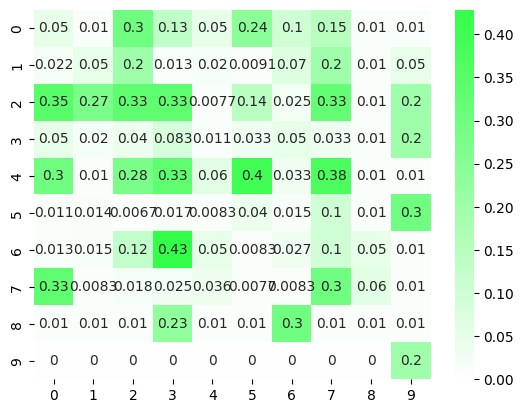

In [6]:
plotHeatmap()


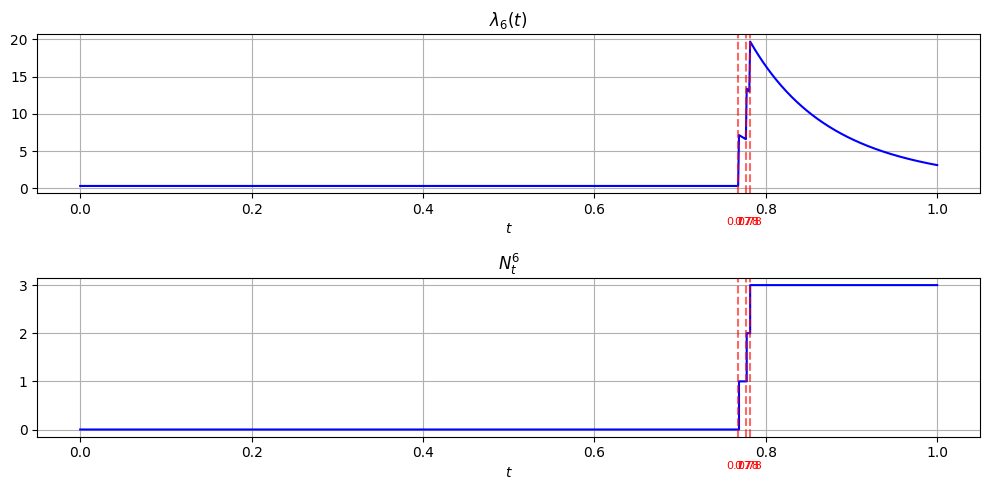

In [17]:
plotIntensity(6,22322)

# SRM Model

In [11]:
class SRMModelExpPoisson():
    def __init__(self, dimension, listOfAlphas, meanJumps, sigmaJumps, nbThreads, mu, alpha, beta, T):
      self.d = dimension
      self.baseline = mu
      self.inhomo = alpha
      self.beta = beta
      self.horizon = T
      self.nbThreads = nbThreads
      self.alpha = listOfAlphas
      self.meanJ = meanJumps
      self.sigmaJ = sigmaJumps


    def simulateRiskFactors(self, nbSimul):
      hawkes_samples =  np.array(hawkes.simulate_hawkes(nbSimul, self.nbThreads, self.baseline, self.inhomo, self.beta, self.horizon)[0])
      #normal_samples = np.random.normal(loc=self.meanJ, scale=self.sigmaJ, size=[nbSimul, self.d])*hawkes_samples
      gamma_samples = np.random.gamma(shape = self.meanJ, scale=self.sigmaJ, size = [nbSimul, self.d])*hawkes_samples
      return gamma_samples.astype(np.float32)
    
    def U(self, X, Y):
        return tf.reduce_mean(tf.math.reduce_sum(tf.maximum(X - Y,0), axis = 1) - 0.5*tf.math.reduce_sum(tf.maximum(Y - X,0), axis = 1))


# Neural networks Config

In [12]:
#Let's define the Neural network
################################################################################

class Net(tf.keras.Model):
    def __init__( self, ndimOut, nbNeurons, activation= tf.nn.tanh):
        super().__init__()
        self.nbNeurons = nbNeurons
        self.name_ = "FeedForward"
        self.ndimOut= ndimOut
        self.ListOfDense =  [layers.Dense( nbNeurons[i],activation= activation, kernel_initializer= tf.keras.initializers.GlorotNormal())  for i in range(len(nbNeurons)) ]+[layers.Dense(ndimOut, activation= None, kernel_initializer= tf.keras.initializers.GlorotNormal())]


    def call(self,inputs):
        x = inputs
        for layer in self.ListOfDense:
            x = layer(x)
        return x

class NetDeterministic(tf.keras.Model):
    def __init__( self, ndimOut):
        super().__init__()
        self.name_ = "TrainableVariables"
        self.ndimOut= ndimOut
        self.Variables = tf.Variable(tf.keras.initializers.GlorotNormal()([self.ndimOut]),  trainable = True, dtype=tf.float32)


    def call(self,inputs):
        return tf.broadcast_to(self.Variables, [inputs.shape[0], self.ndimOut])

class DualVariables(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.name_ = 'DualVariables'
        self.lam = tf.Variable(tf.keras.initializers.GlorotNormal()([]),  trainable = True, dtype=tf.float32)
        self.mu = tf.Variable(tf.keras.initializers.GlorotNormal()([]),  trainable = True, dtype=tf.float32)

# SRM Solver

In [13]:
#Let's train the Neural Network
################################################################################

class SRMSolver():
  def __init__(self, SRMModel, Network, DualVariables, learningRate):
    self.SRM = SRMModel
    self.Net = Network
    self.DV = DualVariables
    self.lRate = learningRate

  def train(self,  batchSize,  batchSizeVal, num_epoch, num_epochExt):
    @tf.function
    def optimizePrimal(nbSimul):
      X = self.SRM.simulateRiskFactors(nbSimul)
      Xnorm = X
      #Xnorm =  (X - tf.reduce_mean(X, axis=0)) / tf.math.reduce_std(X, axis=0)
      Gamma = tf.math.abs(tf.reduce_sum(self.Net(Xnorm), axis = 1)  - tf.reduce_mean(tf.reduce_sum(self.Net(Xnorm), axis = 1)))
      return tf.reduce_mean(tf.reduce_sum(self.Net(Xnorm), axis = 1)) + (self.DV.mu**2)*tf.reduce_mean(Gamma) + (self.DV.lam**2)*(self.SRM.U(X, self.Net(Xnorm)))

    # train to optimize control
    @tf.function
    def trainOpt(nbSimul, optimizer):
        #optimizer.build(self.Net.trainable_variables + self.DV.trainable_variables)
        #Primal
        with tf.GradientTape() as tape:
            objFuncPrimal = optimizePrimal(nbSimul)
        tf.debugging.check_numerics(objFuncPrimal, 'Loss has NaNs')
        gradientsPrimal= tape.gradient(objFuncPrimal, self.Net.trainable_variables)
        optimizer.apply_gradients(zip(gradientsPrimal, self.Net.trainable_variables))
        #Dual
        with tf.GradientTape() as tape:
            objFuncDual = -optimizePrimal(nbSimul)
        gradientsDual= tape.gradient(objFuncDual, self.DV.trainable_variables)
        optimizer.apply_gradients(zip(gradientsDual, self.DV.trainable_variables))
        return objFuncPrimal

    # set the ADAM optimizer
    optimizer= optimizers.Adam(learning_rate = self.lRate, clipvalue=1.0)
    listRho = []
    for iout in range(num_epochExt):
      start_time = time.time()
      for epoch in range(num_epoch):
          # un pas de gradient stochastique
          trainOpt(batchSize, optimizer)
      end_time = time.time()
      rtime = end_time-start_time
      objError = optimizePrimal(batchSizeVal)
      print('estimated SRM' , objError.numpy(), 'dv', self.DV.lam.numpy(), " took %5.3f s" % rtime, 'epoch', iout)
      listRho.append(objError)
    return listRho

# Main

In [20]:
#Parameters
################################################################################
#Deep learning model
nbNeurons = 64
nbLayer = 2
layerSize = nbNeurons*np.ones((nbLayer,), dtype=np.int32)
num_epochExt = 150
num_epoch = 1000
batchSize = 10000
lRate = 3e-5
activation = tf.nn.tanh

#SRM model
utility = 'expo'
riskFactorDistribution = 'Hawkes'

if utility == 'expo' and riskFactorDistribution == 'Hawkes':
    d = 10
    listalpha = np.array([1.11, 1.20, 1.36, 1.89, 1.94, 2.5, 4.0, 1.9, 1.1, 1.2]).astype(np.float32)
    meanJumps = np.ones(d)
    volJumps = 2*np.ones(d)
    # Test the simulate_hawkes function
    mu = np.array([2.0, 1.5, 0.01, 0.1, 0.8, 2.0, 0.3, 0.2, 0.5, 0.01])
    alpha = np.array([
        [0.5, 0.1, 3.0, 2.0, 0.4, 2.4, 0.1, 1.5, 0.1, 0.1],
        [0.2, 0.6, 3.0, 0.1, 0.2, 0.1, 0.7, 1.2, 0.1, 0.5],
        [3.5, 3.0, 4.0, 3.0, 0.1, 2.0, 0.2, 1.3, 0.1, 2.0],
        [0.1, 0.2, 0.2, 0.5, 0.1, 0.1, 0.1, 0.2, 0.1, 2.0],
        [0.3, 0.1, 1.1, 1.0, 0.6, 0.8, 0.1, 1.5, 0.1, 0.1],
        [0.1, 0.2, 0.1, 0.1, 0.1, 0.4, 0.2, 0.1, 0.1, 3.],
        [0.1, 0.2, 2.0, 3.0, 0.5, 0.1, 0.3, 0.1, 0.5, 0.1],
        [3.0, 0.1, 0.3, 0.2, 0.4, 0.1, 0.1, 0.3, 0.6, 0.1],
        [0.1, 0.1, 0.1, 2.3, 0.1, 0.1, 3.0, 0.1, 0.1, 0.1],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0]
    ])
    beta = 2*np.array([
        [5.0, 5.0, 5.0, 7.5, 4.0, 5.0, 0.5, 5.0, 5.0, 5.0],
        [4.5, 6.0, 7.5, 4.0, 5.0, 5.5, 5.0, 3.0, 5.0, 5.0],
        [5.0, 5.5, 6.0, 4.5, 6.5, 7.0, 4.0, 2.0, 5.0, 5.0],
        [1.0, 5.0, 2.5, 3.0, 4.5, 1.5, 1.0, 3.0, 5.0, 5.0],
        [0.5, 5.0, 2.0, 1.5, 5.0, 1.0, 1.5, 2.0, 5.0, 5.0],
        [4.5, 7.0, 7.5, 3.0, 6.0, 5.0, 6.5, 0.5, 5.0, 5.0],
        [4.0, 6.5, 8.0, 3.5, 5.0, 6.0, 5.5, 0.5, 5.0, 5.0],
        [4.5, 6.0, 8.5, 4.0, 5.5, 6.5, 6.0, 0.5, 5.0, 5.0],
        [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
        [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
    ])
    T = 1.0
    nbThreads = 17

estimated SRM -40.811825 dv -0.058469214  took 10.608 s epoch 0
estimated SRM -77.05769 dv -0.09175942  took 5.417 s epoch 1
estimated SRM -99.90558 dv -0.12301225  took 5.606 s epoch 2
estimated SRM -119.26689 dv -0.1534794  took 5.495 s epoch 3
estimated SRM -136.98961 dv -0.18365192  took 5.811 s epoch 4
estimated SRM -153.52695 dv -0.21371558  took 7.142 s epoch 5
estimated SRM -168.9838 dv -0.24373852  took 7.277 s epoch 6
estimated SRM -183.34262 dv -0.27374947  took 7.545 s epoch 7
estimated SRM -196.54018 dv -0.3037604  took 7.161 s epoch 8
estimated SRM -208.4932 dv -0.33377135  took 7.229 s epoch 9
estimated SRM -219.11081 dv -0.3637823  took 7.506 s epoch 10
estimated SRM -228.29588 dv -0.39379323  took 7.082 s epoch 11
estimated SRM -235.94911 dv -0.42380416  took 7.149 s epoch 12
estimated SRM -241.97202 dv -0.4538151  took 7.939 s epoch 13
estimated SRM -246.26254 dv -0.48382604  took 7.282 s epoch 14
estimated SRM -248.72757 dv -0.5138232  took 7.249 s epoch 15
estimated

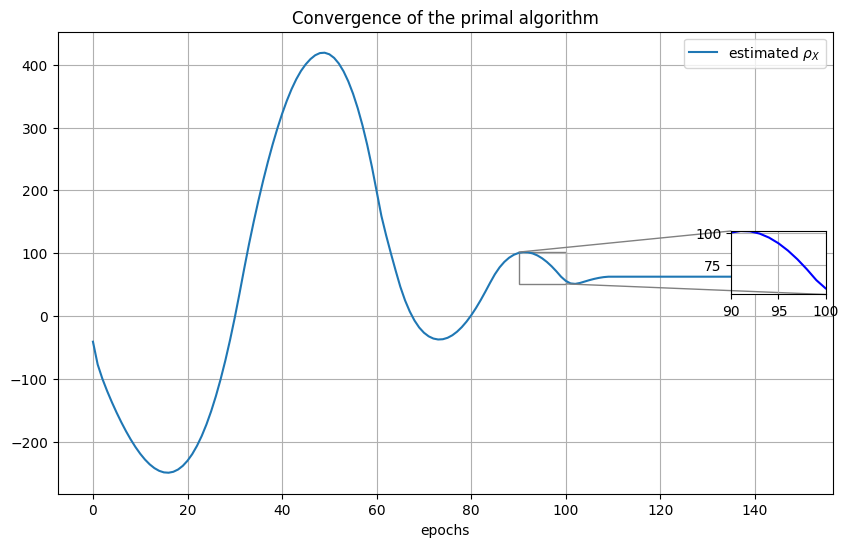

: 

In [ ]:
#SOLVE
################################################################################
SRM = []
for _ in range(1):
    modelSRM = SRMModelExpPoisson(d, listalpha, meanJumps, volJumps, nbThreads, mu, alpha, beta, T)
    NN = Net(d, layerSize, activation)
    DualVar = DualVariables()
    solver = SRMSolver(modelSRM, NN, DualVar, lRate)
    listRho = solver.train(batchSize, 10*batchSize, num_epoch, num_epochExt)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(listRho, label = 'estimated' + r' $\rho_X$')
    #ax.plot(theoretical_value*np.ones(num_epochExt), label = 'explicit formula', linestyle = 'dashed')
    ax.set_title('Convergence of the primal algorithm')
    ax.set_xlabel('epochs')
    ax.legend()
    ax.grid(True)
    # Create the inset plot for zooming into the last few iterations
    zoom_start = 90  # Start zooming in from this epoch
    axins = zoomed_inset_axes(ax, zoom=2, loc='right')
    axins.plot(listRho, color='blue')
    axins.set_xlim(zoom_start, 100)  # Limit the x-axis to the last few iterations
    axins.set_ylim(min(listRho[zoom_start:]), max(listRho[zoom_start:]))
    axins.grid(True)

    # Mark the region of the main plot that is zoomed in
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.show()
    SRM.append(listRho[-1])

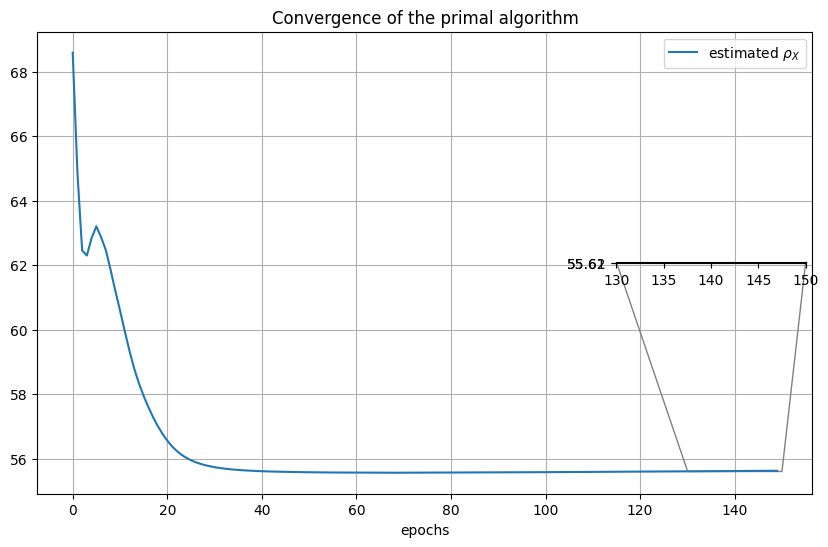

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(listRho, label = 'estimated' + r' $\rho_X$')
#ax.plot(theoretical_value*np.ones(num_epochExt), label = 'explicit formula', linestyle = 'dashed')
ax.set_title('Convergence of the primal algorithm')
ax.set_xlabel('epochs')
ax.legend()
ax.grid(True)
# Create the inset plot for zooming into the last few iterations
zoom_start = 130  # Start zooming in from this epoch
axins = zoomed_inset_axes(ax, zoom=2, loc='right')
axins.plot(listRho, color='blue')
axins.set_xlim(zoom_start, 150)  # Limit the x-axis to the last few iterations
axins.set_ylim(min(listRho[zoom_start:]), max(listRho[zoom_start:]))
axins.grid(True)

# Mark the region of the main plot that is zoomed in
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

In [84]:
listRho[140:]

[<tf.Tensor: shape=(), dtype=float32, numpy=55.618935>,
 <tf.Tensor: shape=(), dtype=float32, numpy=55.619602>,
 <tf.Tensor: shape=(), dtype=float32, numpy=55.620243>,
 <tf.Tensor: shape=(), dtype=float32, numpy=55.6214>,
 <tf.Tensor: shape=(), dtype=float32, numpy=55.62307>,
 <tf.Tensor: shape=(), dtype=float32, numpy=55.623844>,
 <tf.Tensor: shape=(), dtype=float32, numpy=55.62449>,
 <tf.Tensor: shape=(), dtype=float32, numpy=55.62563>,
 <tf.Tensor: shape=(), dtype=float32, numpy=55.626762>,
 <tf.Tensor: shape=(), dtype=float32, numpy=55.627308>]

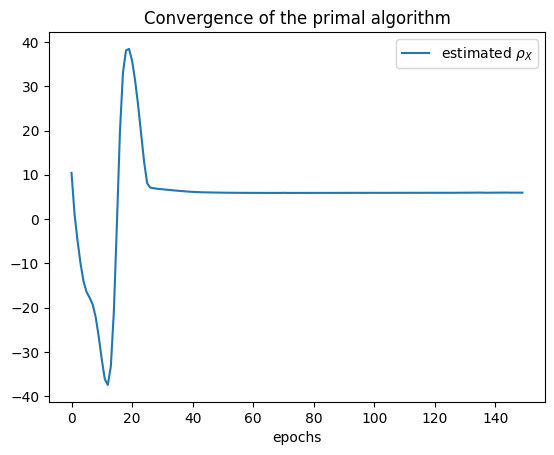

In [86]:
#Compare the estimated and theoretical value of the risk measure in the Gaussian setting
#########################################################################################

plt.plot(listRho, label = 'estimated' + r' $\rho_X$')
#plt.plot(theoretical_value*np.ones(num_epochExt), label = 'explicit formula', linestyle = 'dashed')
plt.title('Convergence of the primal algorithm')
plt.xlabel('epochs')
plt.legend()
plt.show()